In [10]:
import numpy as np
import pandas as pd
import requests
import random
from io import BytesIO
import pickle
from collections import OrderedDict
import os
from os import path
import time
import argparse
import wget
import ast
import json
from PIL import Image, ImageDraw, ImageOps
import ndjson
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# import pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

# import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [11]:
categories = ["apple", "cloud", "diamond", "donut", "door", "mug", "eye", "butterfly", "microphone", "bicycle"]
data_filepath = '../datasets'
num_categories = len(categories)
num_examples = 6000
label_dict = {}
width = 256
height = 256

In [12]:
for i in range(0,num_categories):
    label_dict[i] = categories[i]

Save label dictionary

In [13]:
with open('../service/label_dict.json', 'w') as f:
    json.dump(categories, f)

### Download datasets

Google quickdraw dataset (<a href='https://github.com/googlecreativelab/quickdraw-dataset#the-raw-moderated-dataset'>More</a>)

In [14]:
# URL to dataset in GCP Storage
dataset_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

In [15]:
for category in categories:
    if not os.path.exists(data_filepath + '/' + str(category) + '.npy'):
        print("Start downloading data process for [{}].".format(category))
        url = dataset_url + str(category) + '.npy'
        wget.download(
                    url=url,
                    out=data_filepath
                )
        print("Dataset for {} was successfully downloaded.".format(category))
    else:
        print("Dataset for {} is already downloaded.".format(category))

Dataset for apple is already downloaded.
Dataset for cloud is already downloaded.
Dataset for diamond is already downloaded.
Dataset for donut is already downloaded.
Dataset for door is already downloaded.
Dataset for mug is already downloaded.
Dataset for eye is already downloaded.
Dataset for butterfly is already downloaded.
Dataset for microphone is already downloaded.
Dataset for bicycle is already downloaded.


### Prepare datasets

In [16]:
classes_dict = {}
for category in categories:
    classes_dict[category] = np.load(data_filepath + '/' + str(category) + '.npy')

In [17]:
# Generate labels and add labels to loaded data
for i, (key, value) in enumerate(classes_dict.items()):
    value = value.astype('float32')/255.
    if i == 0:
        classes_dict[key] = np.c_[value, np.zeros(len(value))]
    else:
        classes_dict[key] = np.c_[value,i*np.ones(len(value))]

lst = []
for key, value in classes_dict.items():
    lst.append(value[:num_examples])
tmp = np.concatenate(lst)

# Split the data into features and class labels (X & y respectively)
y = tmp[:,-1].astype('float32')
X = tmp[:,:784]

# Split each dataset into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

### Generate new data

In [18]:
def convert_to_PIL(img):
    img_r = img.reshape(28,28)

    pil_img = Image.new('RGB', (28, 28), 'white')
    pixels = pil_img.load()

    for i in range(0, 28):
        for j in range(0, 28):
            if img_r[i, j] > 0:
                pixels[j, i] = (255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255))

    return pil_img

In [19]:
def convert_to_np(pil_img):
    pil_img = pil_img.convert('RGB')

    img = np.zeros((28, 28))
    pixels = pil_img.load()

    for i in range(0, 28):
        for j in range(0, 28):
            img[i, j] = 1 - pixels[j, i][0] / 255

    return img

In [20]:
def rotate_image(src_im, angle = 45, size = (28,28)):
    dst_im = Image.new("RGBA", size, "white")
    src_im = src_im.convert('RGBA')

    rot = src_im.rotate(angle)
    dst_im.paste(rot, (0, 0), rot)

    return dst_im

In [21]:
def flip_image(src_im):
    dst_im = src_im.transpose(Image.FLIP_LEFT_RIGHT)
    return dst_im

In [22]:
def join_transformed_images(X_train, y_train):
    print("Adding flipped and rotated images to the training set.")

    X_train_new = X_train.copy()
    y_train_new = y_train.copy().reshape(y_train.shape[0], 1)

    for i in range(0, X_train.shape[0]):
        # get image to rotate and flip
        img = X_train[i]
        pil_img = convert_to_PIL(img)

        # get random angle
        angle = random.randint(5, 10)

        # rotate and flip
        rotated = convert_to_np(rotate_image(pil_img, angle))
        flipped = convert_to_np(flip_image(pil_img))

        # add to the original dataset
        X_train_new = np.append(X_train_new, rotated.reshape(1, 784), axis = 0)
        X_train_new = np.append(X_train_new, flipped.reshape(1, 784), axis = 0)
        y_train_new = np.append(y_train_new, y_train[i].reshape(1,1), axis = 0)
        y_train_new = np.append(y_train_new, y_train[i].reshape(1,1), axis = 0)

        # print out progress
        if i % 1000 == 0:
            print("Processed {i} files out of {total}.".format(i= i, total = X_train.shape[0]))

    return X_train_new, y_train_new

In [14]:
X_train, y_train = join_transformed_images(X_train, y_train)

Adding flipped and rotated images to the training set.
Processed 0 files out of 42000.
Processed 1000 files out of 42000.
Processed 2000 files out of 42000.
Processed 3000 files out of 42000.
Processed 4000 files out of 42000.
Processed 5000 files out of 42000.
Processed 6000 files out of 42000.
Processed 7000 files out of 42000.
Processed 8000 files out of 42000.
Processed 9000 files out of 42000.
Processed 10000 files out of 42000.
Processed 11000 files out of 42000.
Processed 12000 files out of 42000.
Processed 13000 files out of 42000.
Processed 14000 files out of 42000.
Processed 15000 files out of 42000.
Processed 16000 files out of 42000.
Processed 17000 files out of 42000.
Processed 18000 files out of 42000.
Processed 19000 files out of 42000.
Processed 20000 files out of 42000.
Processed 21000 files out of 42000.
Processed 22000 files out of 42000.
Processed 23000 files out of 42000.
Processed 24000 files out of 42000.
Processed 25000 files out of 42000.
Processed 26000 files 

### Create stage

In [23]:
def save_np_data(data, file_name):
    with open('{}/{}'.format(data_filepath, file_name), 'wb') as f:
        np.save(f, data)
    
def load_np_data(file_name):
    with open('{}/{}'.format(data_filepath, file_name), 'rb') as f:
        return np.load(f)

In [16]:
save_np_data(X_train, 'X_train.npy')
save_np_data(y_train, 'y_train.npy')

### Load from stage

In [24]:
X_train = load_np_data('X_train.npy')
y_train = load_np_data('y_train.npy')

In [25]:
def view_images_grid(X, y, label_dict):
    fig, axs = plt.subplots(5, 10, figsize=(20,10))
    
    for label_num in range(0,50):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28,28)  #reshape images
        i = label_num // 10
        j = label_num % 10
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(label_dict[int(y[r_label])])

    plt.show()

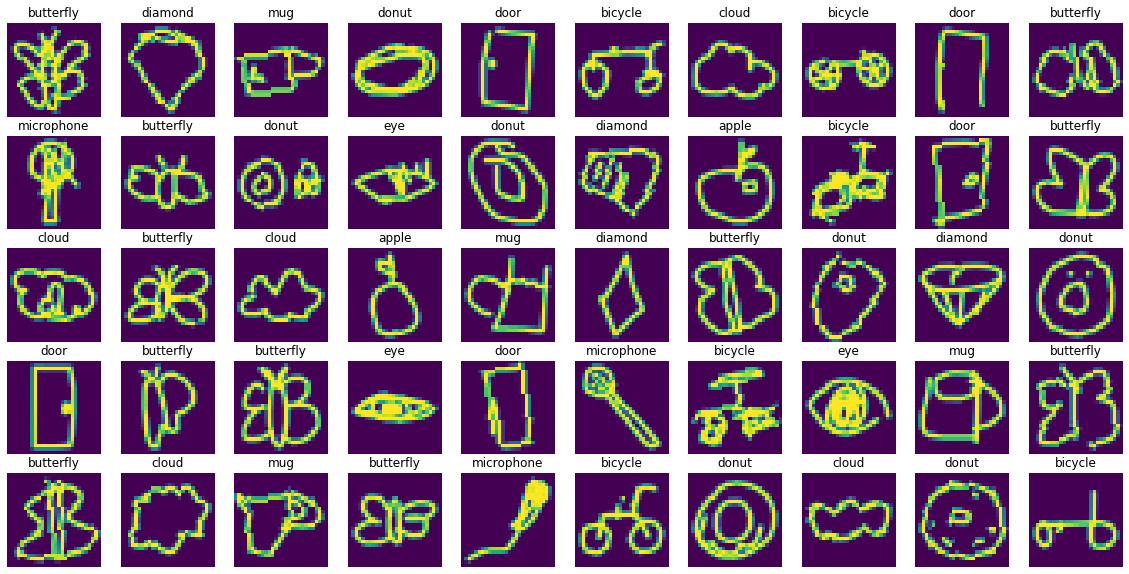

In [26]:
view_images_grid(X_train, y_train, label_dict)

In [27]:
X_tensor_train = torch.from_numpy(X_train).float()
y_tensor_train = torch.from_numpy(y_train).long()
X_tensor_test = torch.from_numpy(X_test).float()
y_tensor_test = torch.from_numpy(y_test).long()

### Describe model

In [28]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 100, 64]
output_size = 10
dropout = 0.0

In [29]:
def build_model(input_size = 784, output_size = 10, hidden_sizes = [128, 100, 64]):
    return nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                            ('bn2', nn.BatchNorm1d(num_features = hidden_sizes[1])),
                            ('relu2', nn.ReLU()),
                            ('dropout', nn.Dropout(dropout)),
                            ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                            ('bn3', nn.BatchNorm1d(num_features = hidden_sizes[2])),
                            ('relu3', nn.ReLU()),
                            ('logits', nn.Linear(hidden_sizes[2], output_size))]))

### Research

In [30]:
train = X_tensor_train
train_labels = y_tensor_train
test = X_tensor_test
test_labels = y_tensor_test

In [31]:
def shuffle(X_train, y_train):
    X_train_shuffled = X_train.numpy()
    y_train_shuffled = y_train.numpy().reshape((X_train.shape[0], 1))

    permutation = list(np.random.permutation(X_train.shape[0]))
    X_train_shuffled = X_train_shuffled[permutation, :]
    y_train_shuffled = y_train_shuffled[permutation, :].reshape((X_train.shape[0], 1))

    X_train_shuffled = torch.from_numpy(X_train_shuffled).float()
    y_train_shuffled = torch.from_numpy(y_train_shuffled).long()

    return X_train_shuffled, y_train_shuffled

In [32]:
def fit_model(model, X_train, y_train, epochs = 100, n_chunks = 1000, learning_rate = 0.003, weight_decay = 0):
    print("Fitting model with epochs = {epochs}, learning rate = {lr}"\
    .format(epochs = epochs, lr = learning_rate))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)

    print_every = 100
    steps = 0

    for e in range(epochs):
        running_loss = 0

        X_train, y_train = shuffle(X_train, y_train)

        images = torch.chunk(X_train, n_chunks)
        labels = torch.chunk(y_train, n_chunks)

        for i in range(n_chunks):
            steps += 1

            optimizer.zero_grad()

            # Forward and backward passes
            output = model.forward(images[i])
            loss = criterion(output, labels[i].squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                print("Epoch: {}/{} ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every))

                running_loss = 0

In [33]:
def get_preds(model, input):
    with torch.no_grad():
        logits = model.forward(input)

    ps = F.softmax(logits, dim=1)
    return ps

In [34]:
def get_labels(pred):
    pred_np = pred.numpy()
    pred_values = np.amax(pred_np, axis=1, keepdims=True)
    pred_labels = np.array([np.where(pred_np[i, :] == pred_values[i, :])[0] for i in range(pred_np.shape[0])])
    pred_labels = pred_labels.reshape(len(pred_np), 1)

    return pred_labels

In [35]:
def evaluate_model(model, train, y_train, test, y_test):
    train_pred = get_preds(model, train)
    train_pred_labels = get_labels(train_pred)

    test_pred = get_preds(model, test)
    test_pred_labels = get_labels(test_pred)

    accuracy_train = accuracy_score(y_train, train_pred_labels)
    accuracy_test = accuracy_score(y_test, test_pred_labels)

    print("Accuracy score for train set is {}".format(accuracy_train))
    print("Accuracy score for test set is {}".format(accuracy_test))
    return accuracy_train, accuracy_test

Plot learning curve depending on the number of epochs.

In [36]:
learning_rate = 0.003
weight_decay = 0.0
n_chunks = 1000

In [30]:
epochs_range = np.arange(10, 150, 10)
train_acc = []
test_acc = []

for epochs in epochs_range:
    model = build_model(input_size, output_size, hidden_sizes)
    fit_model(model, train, train_labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay)
    accuracy_train, accuracy_test = evaluate_model(model, train, train_labels, test, test_labels)

    train_acc.append(accuracy_train)
    test_acc.append(accuracy_test)

Fitting model with epochs = 10, learning rate = 0.003
Epoch: 1/10  Loss: 0.7308
Epoch: 1/10  Loss: 0.4717
Epoch: 1/10  Loss: 0.4212
Epoch: 1/10  Loss: 0.4002
Epoch: 1/10  Loss: 0.3745
Epoch: 1/10  Loss: 0.3699
Epoch: 1/10  Loss: 0.3548
Epoch: 1/10  Loss: 0.3533
Epoch: 1/10  Loss: 0.3298
Epoch: 1/10  Loss: 0.3370
Epoch: 2/10  Loss: 0.2861
Epoch: 2/10  Loss: 0.2899
Epoch: 2/10  Loss: 0.2844
Epoch: 2/10  Loss: 0.2877
Epoch: 2/10  Loss: 0.2964
Epoch: 2/10  Loss: 0.2836
Epoch: 2/10  Loss: 0.2767
Epoch: 2/10  Loss: 0.2756
Epoch: 2/10  Loss: 0.2854
Epoch: 2/10  Loss: 0.2717
Epoch: 3/10  Loss: 0.2328
Epoch: 3/10  Loss: 0.2468
Epoch: 3/10  Loss: 0.2255
Epoch: 3/10  Loss: 0.2434
Epoch: 3/10  Loss: 0.2402
Epoch: 3/10  Loss: 0.2385
Epoch: 3/10  Loss: 0.2442
Epoch: 3/10  Loss: 0.2433
Epoch: 3/10  Loss: 0.2378
Epoch: 3/10  Loss: 0.2391
Epoch: 4/10  Loss: 0.1945
Epoch: 4/10  Loss: 0.2082
Epoch: 4/10  Loss: 0.1999
Epoch: 4/10  Loss: 0.2124
Epoch: 4/10  Loss: 0.2075
Epoch: 4/10  Loss: 0.2145
Epoch: 4/1

Epoch: 1/30  Loss: 0.7234
Epoch: 1/30  Loss: 0.4840
Epoch: 1/30  Loss: 0.4281
Epoch: 1/30  Loss: 0.3991
Epoch: 1/30  Loss: 0.3910
Epoch: 1/30  Loss: 0.3674
Epoch: 1/30  Loss: 0.3500
Epoch: 1/30  Loss: 0.3484
Epoch: 1/30  Loss: 0.3306
Epoch: 1/30  Loss: 0.3311
Epoch: 2/30  Loss: 0.2854
Epoch: 2/30  Loss: 0.3002
Epoch: 2/30  Loss: 0.2919
Epoch: 2/30  Loss: 0.2870
Epoch: 2/30  Loss: 0.2804
Epoch: 2/30  Loss: 0.2788
Epoch: 2/30  Loss: 0.2836
Epoch: 2/30  Loss: 0.2784
Epoch: 2/30  Loss: 0.2693
Epoch: 2/30  Loss: 0.2851
Epoch: 3/30  Loss: 0.2209
Epoch: 3/30  Loss: 0.2288
Epoch: 3/30  Loss: 0.2454
Epoch: 3/30  Loss: 0.2440
Epoch: 3/30  Loss: 0.2440
Epoch: 3/30  Loss: 0.2503
Epoch: 3/30  Loss: 0.2501
Epoch: 3/30  Loss: 0.2423
Epoch: 3/30  Loss: 0.2259
Epoch: 3/30  Loss: 0.2455
Epoch: 4/30  Loss: 0.1935
Epoch: 4/30  Loss: 0.1983
Epoch: 4/30  Loss: 0.1996
Epoch: 4/30  Loss: 0.2219
Epoch: 4/30  Loss: 0.2155
Epoch: 4/30  Loss: 0.2218
Epoch: 4/30  Loss: 0.2121
Epoch: 4/30  Loss: 0.2096
Epoch: 4/30 

Epoch: 1/40  Loss: 0.4270
Epoch: 1/40  Loss: 0.3982
Epoch: 1/40  Loss: 0.3783
Epoch: 1/40  Loss: 0.3694
Epoch: 1/40  Loss: 0.3539
Epoch: 1/40  Loss: 0.3380
Epoch: 1/40  Loss: 0.3441
Epoch: 1/40  Loss: 0.3167
Epoch: 2/40  Loss: 0.2902
Epoch: 2/40  Loss: 0.2880
Epoch: 2/40  Loss: 0.2858
Epoch: 2/40  Loss: 0.2832
Epoch: 2/40  Loss: 0.2804
Epoch: 2/40  Loss: 0.2848
Epoch: 2/40  Loss: 0.2998
Epoch: 2/40  Loss: 0.2834
Epoch: 2/40  Loss: 0.2676
Epoch: 2/40  Loss: 0.2825
Epoch: 3/40  Loss: 0.2304
Epoch: 3/40  Loss: 0.2449
Epoch: 3/40  Loss: 0.2301
Epoch: 3/40  Loss: 0.2317
Epoch: 3/40  Loss: 0.2541
Epoch: 3/40  Loss: 0.2478
Epoch: 3/40  Loss: 0.2379
Epoch: 3/40  Loss: 0.2439
Epoch: 3/40  Loss: 0.2359
Epoch: 3/40  Loss: 0.2361
Epoch: 4/40  Loss: 0.1985
Epoch: 4/40  Loss: 0.2104
Epoch: 4/40  Loss: 0.2071
Epoch: 4/40  Loss: 0.2008
Epoch: 4/40  Loss: 0.2111
Epoch: 4/40  Loss: 0.2109
Epoch: 4/40  Loss: 0.2011
Epoch: 4/40  Loss: 0.2122
Epoch: 4/40  Loss: 0.2190
Epoch: 4/40  Loss: 0.2066
Epoch: 5/40 

Epoch: 31/40  Loss: 0.0413
Epoch: 32/40  Loss: 0.0332
Epoch: 32/40  Loss: 0.0301
Epoch: 32/40  Loss: 0.0312
Epoch: 32/40  Loss: 0.0322
Epoch: 32/40  Loss: 0.0370
Epoch: 32/40  Loss: 0.0342
Epoch: 32/40  Loss: 0.0379
Epoch: 32/40  Loss: 0.0388
Epoch: 32/40  Loss: 0.0388
Epoch: 32/40  Loss: 0.0419
Epoch: 33/40  Loss: 0.0263
Epoch: 33/40  Loss: 0.0280
Epoch: 33/40  Loss: 0.0260
Epoch: 33/40  Loss: 0.0308
Epoch: 33/40  Loss: 0.0310
Epoch: 33/40  Loss: 0.0319
Epoch: 33/40  Loss: 0.0312
Epoch: 33/40  Loss: 0.0353
Epoch: 33/40  Loss: 0.0402
Epoch: 33/40  Loss: 0.0416
Epoch: 34/40  Loss: 0.0274
Epoch: 34/40  Loss: 0.0283
Epoch: 34/40  Loss: 0.0284
Epoch: 34/40  Loss: 0.0302
Epoch: 34/40  Loss: 0.0305
Epoch: 34/40  Loss: 0.0371
Epoch: 34/40  Loss: 0.0324
Epoch: 34/40  Loss: 0.0362
Epoch: 34/40  Loss: 0.0383
Epoch: 34/40  Loss: 0.0311
Epoch: 35/40  Loss: 0.0198
Epoch: 35/40  Loss: 0.0191
Epoch: 35/40  Loss: 0.0259
Epoch: 35/40  Loss: 0.0325
Epoch: 35/40  Loss: 0.0316
Epoch: 35/40  Loss: 0.0332
E

Epoch: 22/50  Loss: 0.0430
Epoch: 22/50  Loss: 0.0532
Epoch: 22/50  Loss: 0.0526
Epoch: 22/50  Loss: 0.0466
Epoch: 22/50  Loss: 0.0492
Epoch: 22/50  Loss: 0.0550
Epoch: 22/50  Loss: 0.0518
Epoch: 22/50  Loss: 0.0519
Epoch: 22/50  Loss: 0.0594
Epoch: 23/50  Loss: 0.0386
Epoch: 23/50  Loss: 0.0407
Epoch: 23/50  Loss: 0.0424
Epoch: 23/50  Loss: 0.0400
Epoch: 23/50  Loss: 0.0520
Epoch: 23/50  Loss: 0.0512
Epoch: 23/50  Loss: 0.0555
Epoch: 23/50  Loss: 0.0563
Epoch: 23/50  Loss: 0.0520
Epoch: 23/50  Loss: 0.0525
Epoch: 24/50  Loss: 0.0366
Epoch: 24/50  Loss: 0.0433
Epoch: 24/50  Loss: 0.0443
Epoch: 24/50  Loss: 0.0425
Epoch: 24/50  Loss: 0.0429
Epoch: 24/50  Loss: 0.0473
Epoch: 24/50  Loss: 0.0495
Epoch: 24/50  Loss: 0.0504
Epoch: 24/50  Loss: 0.0531
Epoch: 24/50  Loss: 0.0497
Epoch: 25/50  Loss: 0.0389
Epoch: 25/50  Loss: 0.0343
Epoch: 25/50  Loss: 0.0398
Epoch: 25/50  Loss: 0.0422
Epoch: 25/50  Loss: 0.0443
Epoch: 25/50  Loss: 0.0411
Epoch: 25/50  Loss: 0.0390
Epoch: 25/50  Loss: 0.0487
E

Epoch: 2/60  Loss: 0.2914
Epoch: 2/60  Loss: 0.2947
Epoch: 2/60  Loss: 0.2917
Epoch: 2/60  Loss: 0.2918
Epoch: 2/60  Loss: 0.2877
Epoch: 2/60  Loss: 0.2773
Epoch: 2/60  Loss: 0.2745
Epoch: 2/60  Loss: 0.2697
Epoch: 2/60  Loss: 0.2694
Epoch: 2/60  Loss: 0.2785
Epoch: 3/60  Loss: 0.2275
Epoch: 3/60  Loss: 0.2353
Epoch: 3/60  Loss: 0.2351
Epoch: 3/60  Loss: 0.2386
Epoch: 3/60  Loss: 0.2474
Epoch: 3/60  Loss: 0.2479
Epoch: 3/60  Loss: 0.2470
Epoch: 3/60  Loss: 0.2300
Epoch: 3/60  Loss: 0.2409
Epoch: 3/60  Loss: 0.2315
Epoch: 4/60  Loss: 0.1967
Epoch: 4/60  Loss: 0.2158
Epoch: 4/60  Loss: 0.2024
Epoch: 4/60  Loss: 0.2268
Epoch: 4/60  Loss: 0.2149
Epoch: 4/60  Loss: 0.2120
Epoch: 4/60  Loss: 0.1970
Epoch: 4/60  Loss: 0.2045
Epoch: 4/60  Loss: 0.2110
Epoch: 4/60  Loss: 0.2023
Epoch: 5/60  Loss: 0.1661
Epoch: 5/60  Loss: 0.1800
Epoch: 5/60  Loss: 0.1623
Epoch: 5/60  Loss: 0.1962
Epoch: 5/60  Loss: 0.1821
Epoch: 5/60  Loss: 0.1842
Epoch: 5/60  Loss: 0.1897
Epoch: 5/60  Loss: 0.1918
Epoch: 5/60 

Epoch: 32/60  Loss: 0.0327
Epoch: 32/60  Loss: 0.0364
Epoch: 32/60  Loss: 0.0397
Epoch: 33/60  Loss: 0.0305
Epoch: 33/60  Loss: 0.0266
Epoch: 33/60  Loss: 0.0307
Epoch: 33/60  Loss: 0.0345
Epoch: 33/60  Loss: 0.0338
Epoch: 33/60  Loss: 0.0368
Epoch: 33/60  Loss: 0.0364
Epoch: 33/60  Loss: 0.0343
Epoch: 33/60  Loss: 0.0336
Epoch: 33/60  Loss: 0.0404
Epoch: 34/60  Loss: 0.0239
Epoch: 34/60  Loss: 0.0282
Epoch: 34/60  Loss: 0.0276
Epoch: 34/60  Loss: 0.0275
Epoch: 34/60  Loss: 0.0353
Epoch: 34/60  Loss: 0.0388
Epoch: 34/60  Loss: 0.0298
Epoch: 34/60  Loss: 0.0368
Epoch: 34/60  Loss: 0.0345
Epoch: 34/60  Loss: 0.0362
Epoch: 35/60  Loss: 0.0241
Epoch: 35/60  Loss: 0.0250
Epoch: 35/60  Loss: 0.0278
Epoch: 35/60  Loss: 0.0282
Epoch: 35/60  Loss: 0.0276
Epoch: 35/60  Loss: 0.0289
Epoch: 35/60  Loss: 0.0308
Epoch: 35/60  Loss: 0.0384
Epoch: 35/60  Loss: 0.0352
Epoch: 35/60  Loss: 0.0305
Epoch: 36/60  Loss: 0.0220
Epoch: 36/60  Loss: 0.0225
Epoch: 36/60  Loss: 0.0268
Epoch: 36/60  Loss: 0.0245
E

Epoch: 2/70  Loss: 0.2883
Epoch: 2/70  Loss: 0.2777
Epoch: 2/70  Loss: 0.2696
Epoch: 2/70  Loss: 0.2644
Epoch: 3/70  Loss: 0.2318
Epoch: 3/70  Loss: 0.2338
Epoch: 3/70  Loss: 0.2297
Epoch: 3/70  Loss: 0.2474
Epoch: 3/70  Loss: 0.2444
Epoch: 3/70  Loss: 0.2458
Epoch: 3/70  Loss: 0.2369
Epoch: 3/70  Loss: 0.2447
Epoch: 3/70  Loss: 0.2441
Epoch: 3/70  Loss: 0.2224
Epoch: 4/70  Loss: 0.2026
Epoch: 4/70  Loss: 0.1936
Epoch: 4/70  Loss: 0.2013
Epoch: 4/70  Loss: 0.2082
Epoch: 4/70  Loss: 0.2006
Epoch: 4/70  Loss: 0.2162
Epoch: 4/70  Loss: 0.2057
Epoch: 4/70  Loss: 0.2144
Epoch: 4/70  Loss: 0.2039
Epoch: 4/70  Loss: 0.2106
Epoch: 5/70  Loss: 0.1625
Epoch: 5/70  Loss: 0.1812
Epoch: 5/70  Loss: 0.1835
Epoch: 5/70  Loss: 0.1974
Epoch: 5/70  Loss: 0.1845
Epoch: 5/70  Loss: 0.1975
Epoch: 5/70  Loss: 0.1771
Epoch: 5/70  Loss: 0.1989
Epoch: 5/70  Loss: 0.1886
Epoch: 5/70  Loss: 0.1913
Epoch: 6/70  Loss: 0.1618
Epoch: 6/70  Loss: 0.1559
Epoch: 6/70  Loss: 0.1653
Epoch: 6/70  Loss: 0.1650
Epoch: 6/70 

Epoch: 33/70  Loss: 0.0293
Epoch: 33/70  Loss: 0.0359
Epoch: 33/70  Loss: 0.0369
Epoch: 33/70  Loss: 0.0389
Epoch: 33/70  Loss: 0.0376
Epoch: 33/70  Loss: 0.0408
Epoch: 33/70  Loss: 0.0389
Epoch: 34/70  Loss: 0.0286
Epoch: 34/70  Loss: 0.0274
Epoch: 34/70  Loss: 0.0303
Epoch: 34/70  Loss: 0.0259
Epoch: 34/70  Loss: 0.0277
Epoch: 34/70  Loss: 0.0273
Epoch: 34/70  Loss: 0.0317
Epoch: 34/70  Loss: 0.0326
Epoch: 34/70  Loss: 0.0354
Epoch: 34/70  Loss: 0.0370
Epoch: 35/70  Loss: 0.0313
Epoch: 35/70  Loss: 0.0264
Epoch: 35/70  Loss: 0.0247
Epoch: 35/70  Loss: 0.0242
Epoch: 35/70  Loss: 0.0303
Epoch: 35/70  Loss: 0.0263
Epoch: 35/70  Loss: 0.0360
Epoch: 35/70  Loss: 0.0349
Epoch: 35/70  Loss: 0.0309
Epoch: 35/70  Loss: 0.0296
Epoch: 36/70  Loss: 0.0242
Epoch: 36/70  Loss: 0.0221
Epoch: 36/70  Loss: 0.0249
Epoch: 36/70  Loss: 0.0279
Epoch: 36/70  Loss: 0.0276
Epoch: 36/70  Loss: 0.0273
Epoch: 36/70  Loss: 0.0303
Epoch: 36/70  Loss: 0.0357
Epoch: 36/70  Loss: 0.0324
Epoch: 36/70  Loss: 0.0322
E

Epoch: 63/70  Loss: 0.0150
Epoch: 63/70  Loss: 0.0176
Epoch: 63/70  Loss: 0.0182
Epoch: 64/70  Loss: 0.0143
Epoch: 64/70  Loss: 0.0149
Epoch: 64/70  Loss: 0.0125
Epoch: 64/70  Loss: 0.0133
Epoch: 64/70  Loss: 0.0152
Epoch: 64/70  Loss: 0.0138
Epoch: 64/70  Loss: 0.0221
Epoch: 64/70  Loss: 0.0230
Epoch: 64/70  Loss: 0.0216
Epoch: 64/70  Loss: 0.0205
Epoch: 65/70  Loss: 0.0126
Epoch: 65/70  Loss: 0.0128
Epoch: 65/70  Loss: 0.0150
Epoch: 65/70  Loss: 0.0130
Epoch: 65/70  Loss: 0.0157
Epoch: 65/70  Loss: 0.0193
Epoch: 65/70  Loss: 0.0222
Epoch: 65/70  Loss: 0.0208
Epoch: 65/70  Loss: 0.0180
Epoch: 65/70  Loss: 0.0150
Epoch: 66/70  Loss: 0.0109
Epoch: 66/70  Loss: 0.0133
Epoch: 66/70  Loss: 0.0122
Epoch: 66/70  Loss: 0.0173
Epoch: 66/70  Loss: 0.0156
Epoch: 66/70  Loss: 0.0193
Epoch: 66/70  Loss: 0.0166
Epoch: 66/70  Loss: 0.0193
Epoch: 66/70  Loss: 0.0202
Epoch: 66/70  Loss: 0.0198
Epoch: 67/70  Loss: 0.0208
Epoch: 67/70  Loss: 0.0184
Epoch: 67/70  Loss: 0.0156
Epoch: 67/70  Loss: 0.0139
E

Epoch: 23/80  Loss: 0.0604
Epoch: 24/80  Loss: 0.0458
Epoch: 24/80  Loss: 0.0405
Epoch: 24/80  Loss: 0.0444
Epoch: 24/80  Loss: 0.0504
Epoch: 24/80  Loss: 0.0479
Epoch: 24/80  Loss: 0.0522
Epoch: 24/80  Loss: 0.0518
Epoch: 24/80  Loss: 0.0520
Epoch: 24/80  Loss: 0.0515
Epoch: 24/80  Loss: 0.0558
Epoch: 25/80  Loss: 0.0395
Epoch: 25/80  Loss: 0.0387
Epoch: 25/80  Loss: 0.0352
Epoch: 25/80  Loss: 0.0412
Epoch: 25/80  Loss: 0.0466
Epoch: 25/80  Loss: 0.0497
Epoch: 25/80  Loss: 0.0575
Epoch: 25/80  Loss: 0.0500
Epoch: 25/80  Loss: 0.0553
Epoch: 25/80  Loss: 0.0550
Epoch: 26/80  Loss: 0.0429
Epoch: 26/80  Loss: 0.0433
Epoch: 26/80  Loss: 0.0429
Epoch: 26/80  Loss: 0.0368
Epoch: 26/80  Loss: 0.0460
Epoch: 26/80  Loss: 0.0433
Epoch: 26/80  Loss: 0.0418
Epoch: 26/80  Loss: 0.0519
Epoch: 26/80  Loss: 0.0503
Epoch: 26/80  Loss: 0.0482
Epoch: 27/80  Loss: 0.0369
Epoch: 27/80  Loss: 0.0369
Epoch: 27/80  Loss: 0.0394
Epoch: 27/80  Loss: 0.0377
Epoch: 27/80  Loss: 0.0360
Epoch: 27/80  Loss: 0.0446
E

Epoch: 54/80  Loss: 0.0236
Epoch: 54/80  Loss: 0.0177
Epoch: 54/80  Loss: 0.0205
Epoch: 54/80  Loss: 0.0259
Epoch: 54/80  Loss: 0.0210
Epoch: 54/80  Loss: 0.0280
Epoch: 54/80  Loss: 0.0292
Epoch: 55/80  Loss: 0.0212
Epoch: 55/80  Loss: 0.0203
Epoch: 55/80  Loss: 0.0193
Epoch: 55/80  Loss: 0.0210
Epoch: 55/80  Loss: 0.0197
Epoch: 55/80  Loss: 0.0220
Epoch: 55/80  Loss: 0.0176
Epoch: 55/80  Loss: 0.0201
Epoch: 55/80  Loss: 0.0256
Epoch: 55/80  Loss: 0.0241
Epoch: 56/80  Loss: 0.0151
Epoch: 56/80  Loss: 0.0211
Epoch: 56/80  Loss: 0.0153
Epoch: 56/80  Loss: 0.0170
Epoch: 56/80  Loss: 0.0175
Epoch: 56/80  Loss: 0.0208
Epoch: 56/80  Loss: 0.0246
Epoch: 56/80  Loss: 0.0255
Epoch: 56/80  Loss: 0.0287
Epoch: 56/80  Loss: 0.0272
Epoch: 57/80  Loss: 0.0228
Epoch: 57/80  Loss: 0.0181
Epoch: 57/80  Loss: 0.0176
Epoch: 57/80  Loss: 0.0195
Epoch: 57/80  Loss: 0.0283
Epoch: 57/80  Loss: 0.0213
Epoch: 57/80  Loss: 0.0222
Epoch: 57/80  Loss: 0.0234
Epoch: 57/80  Loss: 0.0203
Epoch: 57/80  Loss: 0.0208
E

Epoch: 4/90  Loss: 0.2074
Epoch: 4/90  Loss: 0.1967
Epoch: 4/90  Loss: 0.2180
Epoch: 4/90  Loss: 0.2070
Epoch: 4/90  Loss: 0.2075
Epoch: 4/90  Loss: 0.2080
Epoch: 4/90  Loss: 0.2099
Epoch: 4/90  Loss: 0.2079
Epoch: 5/90  Loss: 0.1705
Epoch: 5/90  Loss: 0.1744
Epoch: 5/90  Loss: 0.1729
Epoch: 5/90  Loss: 0.1682
Epoch: 5/90  Loss: 0.1949
Epoch: 5/90  Loss: 0.1869
Epoch: 5/90  Loss: 0.1982
Epoch: 5/90  Loss: 0.1833
Epoch: 5/90  Loss: 0.1896
Epoch: 5/90  Loss: 0.1918
Epoch: 6/90  Loss: 0.1478
Epoch: 6/90  Loss: 0.1516
Epoch: 6/90  Loss: 0.1564
Epoch: 6/90  Loss: 0.1591
Epoch: 6/90  Loss: 0.1667
Epoch: 6/90  Loss: 0.1740
Epoch: 6/90  Loss: 0.1622
Epoch: 6/90  Loss: 0.1654
Epoch: 6/90  Loss: 0.1831
Epoch: 6/90  Loss: 0.1671
Epoch: 7/90  Loss: 0.1343
Epoch: 7/90  Loss: 0.1412
Epoch: 7/90  Loss: 0.1366
Epoch: 7/90  Loss: 0.1448
Epoch: 7/90  Loss: 0.1452
Epoch: 7/90  Loss: 0.1582
Epoch: 7/90  Loss: 0.1453
Epoch: 7/90  Loss: 0.1551
Epoch: 7/90  Loss: 0.1684
Epoch: 7/90  Loss: 0.1531
Epoch: 8/90 

Epoch: 34/90  Loss: 0.0339
Epoch: 34/90  Loss: 0.0365
Epoch: 35/90  Loss: 0.0254
Epoch: 35/90  Loss: 0.0290
Epoch: 35/90  Loss: 0.0288
Epoch: 35/90  Loss: 0.0285
Epoch: 35/90  Loss: 0.0342
Epoch: 35/90  Loss: 0.0339
Epoch: 35/90  Loss: 0.0412
Epoch: 35/90  Loss: 0.0297
Epoch: 35/90  Loss: 0.0301
Epoch: 35/90  Loss: 0.0311
Epoch: 36/90  Loss: 0.0229
Epoch: 36/90  Loss: 0.0212
Epoch: 36/90  Loss: 0.0261
Epoch: 36/90  Loss: 0.0316
Epoch: 36/90  Loss: 0.0331
Epoch: 36/90  Loss: 0.0329
Epoch: 36/90  Loss: 0.0344
Epoch: 36/90  Loss: 0.0360
Epoch: 36/90  Loss: 0.0305
Epoch: 36/90  Loss: 0.0310
Epoch: 37/90  Loss: 0.0221
Epoch: 37/90  Loss: 0.0288
Epoch: 37/90  Loss: 0.0298
Epoch: 37/90  Loss: 0.0277
Epoch: 37/90  Loss: 0.0329
Epoch: 37/90  Loss: 0.0304
Epoch: 37/90  Loss: 0.0363
Epoch: 37/90  Loss: 0.0335
Epoch: 37/90  Loss: 0.0361
Epoch: 37/90  Loss: 0.0342
Epoch: 38/90  Loss: 0.0229
Epoch: 38/90  Loss: 0.0240
Epoch: 38/90  Loss: 0.0237
Epoch: 38/90  Loss: 0.0311
Epoch: 38/90  Loss: 0.0266
E

Epoch: 65/90  Loss: 0.0149
Epoch: 65/90  Loss: 0.0169
Epoch: 65/90  Loss: 0.0174
Epoch: 65/90  Loss: 0.0237
Epoch: 65/90  Loss: 0.0214
Epoch: 65/90  Loss: 0.0212
Epoch: 65/90  Loss: 0.0249
Epoch: 65/90  Loss: 0.0153
Epoch: 66/90  Loss: 0.0139
Epoch: 66/90  Loss: 0.0167
Epoch: 66/90  Loss: 0.0147
Epoch: 66/90  Loss: 0.0127
Epoch: 66/90  Loss: 0.0164
Epoch: 66/90  Loss: 0.0155
Epoch: 66/90  Loss: 0.0177
Epoch: 66/90  Loss: 0.0172
Epoch: 66/90  Loss: 0.0160
Epoch: 66/90  Loss: 0.0166
Epoch: 67/90  Loss: 0.0139
Epoch: 67/90  Loss: 0.0136
Epoch: 67/90  Loss: 0.0164
Epoch: 67/90  Loss: 0.0161
Epoch: 67/90  Loss: 0.0173
Epoch: 67/90  Loss: 0.0225
Epoch: 67/90  Loss: 0.0238
Epoch: 67/90  Loss: 0.0190
Epoch: 67/90  Loss: 0.0216
Epoch: 67/90  Loss: 0.0168
Epoch: 68/90  Loss: 0.0128
Epoch: 68/90  Loss: 0.0139
Epoch: 68/90  Loss: 0.0143
Epoch: 68/90  Loss: 0.0148
Epoch: 68/90  Loss: 0.0153
Epoch: 68/90  Loss: 0.0151
Epoch: 68/90  Loss: 0.0169
Epoch: 68/90  Loss: 0.0216
Epoch: 68/90  Loss: 0.0206
E

Epoch: 5/100  Loss: 0.1767
Epoch: 5/100  Loss: 0.1628
Epoch: 5/100  Loss: 0.1812
Epoch: 5/100  Loss: 0.1826
Epoch: 5/100  Loss: 0.1692
Epoch: 5/100  Loss: 0.1770
Epoch: 5/100  Loss: 0.1968
Epoch: 5/100  Loss: 0.1808
Epoch: 5/100  Loss: 0.2017
Epoch: 5/100  Loss: 0.2005
Epoch: 6/100  Loss: 0.1455
Epoch: 6/100  Loss: 0.1640
Epoch: 6/100  Loss: 0.1531
Epoch: 6/100  Loss: 0.1675
Epoch: 6/100  Loss: 0.1627
Epoch: 6/100  Loss: 0.1581
Epoch: 6/100  Loss: 0.1772
Epoch: 6/100  Loss: 0.1699
Epoch: 6/100  Loss: 0.1675
Epoch: 6/100  Loss: 0.1745
Epoch: 7/100  Loss: 0.1350
Epoch: 7/100  Loss: 0.1422
Epoch: 7/100  Loss: 0.1410
Epoch: 7/100  Loss: 0.1414
Epoch: 7/100  Loss: 0.1577
Epoch: 7/100  Loss: 0.1525
Epoch: 7/100  Loss: 0.1474
Epoch: 7/100  Loss: 0.1522
Epoch: 7/100  Loss: 0.1550
Epoch: 7/100  Loss: 0.1644
Epoch: 8/100  Loss: 0.1204
Epoch: 8/100  Loss: 0.1129
Epoch: 8/100  Loss: 0.1365
Epoch: 8/100  Loss: 0.1283
Epoch: 8/100  Loss: 0.1322
Epoch: 8/100  Loss: 0.1421
Epoch: 8/100  Loss: 0.1353
E

Epoch: 34/100  Loss: 0.0317
Epoch: 34/100  Loss: 0.0361
Epoch: 34/100  Loss: 0.0411
Epoch: 34/100  Loss: 0.0419
Epoch: 34/100  Loss: 0.0493
Epoch: 35/100  Loss: 0.0254
Epoch: 35/100  Loss: 0.0266
Epoch: 35/100  Loss: 0.0252
Epoch: 35/100  Loss: 0.0259
Epoch: 35/100  Loss: 0.0238
Epoch: 35/100  Loss: 0.0238
Epoch: 35/100  Loss: 0.0302
Epoch: 35/100  Loss: 0.0332
Epoch: 35/100  Loss: 0.0337
Epoch: 35/100  Loss: 0.0340
Epoch: 36/100  Loss: 0.0286
Epoch: 36/100  Loss: 0.0240
Epoch: 36/100  Loss: 0.0276
Epoch: 36/100  Loss: 0.0274
Epoch: 36/100  Loss: 0.0281
Epoch: 36/100  Loss: 0.0301
Epoch: 36/100  Loss: 0.0315
Epoch: 36/100  Loss: 0.0306
Epoch: 36/100  Loss: 0.0399
Epoch: 36/100  Loss: 0.0377
Epoch: 37/100  Loss: 0.0245
Epoch: 37/100  Loss: 0.0235
Epoch: 37/100  Loss: 0.0279
Epoch: 37/100  Loss: 0.0259
Epoch: 37/100  Loss: 0.0225
Epoch: 37/100  Loss: 0.0334
Epoch: 37/100  Loss: 0.0351
Epoch: 37/100  Loss: 0.0350
Epoch: 37/100  Loss: 0.0316
Epoch: 37/100  Loss: 0.0273
Epoch: 38/100  Loss:

Epoch: 63/100  Loss: 0.0167
Epoch: 63/100  Loss: 0.0182
Epoch: 64/100  Loss: 0.0151
Epoch: 64/100  Loss: 0.0144
Epoch: 64/100  Loss: 0.0130
Epoch: 64/100  Loss: 0.0170
Epoch: 64/100  Loss: 0.0179
Epoch: 64/100  Loss: 0.0207
Epoch: 64/100  Loss: 0.0196
Epoch: 64/100  Loss: 0.0172
Epoch: 64/100  Loss: 0.0176
Epoch: 64/100  Loss: 0.0208
Epoch: 65/100  Loss: 0.0150
Epoch: 65/100  Loss: 0.0168
Epoch: 65/100  Loss: 0.0207
Epoch: 65/100  Loss: 0.0168
Epoch: 65/100  Loss: 0.0140
Epoch: 65/100  Loss: 0.0185
Epoch: 65/100  Loss: 0.0143
Epoch: 65/100  Loss: 0.0169
Epoch: 65/100  Loss: 0.0163
Epoch: 65/100  Loss: 0.0195
Epoch: 66/100  Loss: 0.0159
Epoch: 66/100  Loss: 0.0108
Epoch: 66/100  Loss: 0.0102
Epoch: 66/100  Loss: 0.0132
Epoch: 66/100  Loss: 0.0142
Epoch: 66/100  Loss: 0.0195
Epoch: 66/100  Loss: 0.0221
Epoch: 66/100  Loss: 0.0260
Epoch: 66/100  Loss: 0.0174
Epoch: 66/100  Loss: 0.0179
Epoch: 67/100  Loss: 0.0138
Epoch: 67/100  Loss: 0.0179
Epoch: 67/100  Loss: 0.0129
Epoch: 67/100  Loss:

Epoch: 93/100  Loss: 0.0110
Epoch: 93/100  Loss: 0.0136
Epoch: 93/100  Loss: 0.0147
Epoch: 93/100  Loss: 0.0145
Epoch: 93/100  Loss: 0.0121
Epoch: 93/100  Loss: 0.0127
Epoch: 93/100  Loss: 0.0145
Epoch: 93/100  Loss: 0.0134
Epoch: 93/100  Loss: 0.0156
Epoch: 94/100  Loss: 0.0108
Epoch: 94/100  Loss: 0.0097
Epoch: 94/100  Loss: 0.0110
Epoch: 94/100  Loss: 0.0107
Epoch: 94/100  Loss: 0.0089
Epoch: 94/100  Loss: 0.0108
Epoch: 94/100  Loss: 0.0110
Epoch: 94/100  Loss: 0.0099
Epoch: 94/100  Loss: 0.0146
Epoch: 94/100  Loss: 0.0197
Epoch: 95/100  Loss: 0.0096
Epoch: 95/100  Loss: 0.0087
Epoch: 95/100  Loss: 0.0089
Epoch: 95/100  Loss: 0.0105
Epoch: 95/100  Loss: 0.0111
Epoch: 95/100  Loss: 0.0152
Epoch: 95/100  Loss: 0.0127
Epoch: 95/100  Loss: 0.0098
Epoch: 95/100  Loss: 0.0113
Epoch: 95/100  Loss: 0.0118
Epoch: 96/100  Loss: 0.0094
Epoch: 96/100  Loss: 0.0085
Epoch: 96/100  Loss: 0.0086
Epoch: 96/100  Loss: 0.0076
Epoch: 96/100  Loss: 0.0092
Epoch: 96/100  Loss: 0.0106
Epoch: 96/100  Loss:

Epoch: 22/110  Loss: 0.0398
Epoch: 22/110  Loss: 0.0401
Epoch: 22/110  Loss: 0.0411
Epoch: 22/110  Loss: 0.0528
Epoch: 22/110  Loss: 0.0519
Epoch: 22/110  Loss: 0.0502
Epoch: 22/110  Loss: 0.0584
Epoch: 22/110  Loss: 0.0508
Epoch: 22/110  Loss: 0.0497
Epoch: 23/110  Loss: 0.0400
Epoch: 23/110  Loss: 0.0383
Epoch: 23/110  Loss: 0.0386
Epoch: 23/110  Loss: 0.0419
Epoch: 23/110  Loss: 0.0440
Epoch: 23/110  Loss: 0.0469
Epoch: 23/110  Loss: 0.0468
Epoch: 23/110  Loss: 0.0468
Epoch: 23/110  Loss: 0.0587
Epoch: 23/110  Loss: 0.0557
Epoch: 24/110  Loss: 0.0374
Epoch: 24/110  Loss: 0.0369
Epoch: 24/110  Loss: 0.0397
Epoch: 24/110  Loss: 0.0481
Epoch: 24/110  Loss: 0.0472
Epoch: 24/110  Loss: 0.0453
Epoch: 24/110  Loss: 0.0528
Epoch: 24/110  Loss: 0.0457
Epoch: 24/110  Loss: 0.0500
Epoch: 24/110  Loss: 0.0540
Epoch: 25/110  Loss: 0.0333
Epoch: 25/110  Loss: 0.0382
Epoch: 25/110  Loss: 0.0332
Epoch: 25/110  Loss: 0.0405
Epoch: 25/110  Loss: 0.0427
Epoch: 25/110  Loss: 0.0467
Epoch: 25/110  Loss:

Epoch: 51/110  Loss: 0.0197
Epoch: 51/110  Loss: 0.0177
Epoch: 51/110  Loss: 0.0162
Epoch: 51/110  Loss: 0.0216
Epoch: 51/110  Loss: 0.0241
Epoch: 51/110  Loss: 0.0221
Epoch: 52/110  Loss: 0.0237
Epoch: 52/110  Loss: 0.0170
Epoch: 52/110  Loss: 0.0171
Epoch: 52/110  Loss: 0.0234
Epoch: 52/110  Loss: 0.0220
Epoch: 52/110  Loss: 0.0234
Epoch: 52/110  Loss: 0.0291
Epoch: 52/110  Loss: 0.0219
Epoch: 52/110  Loss: 0.0240
Epoch: 52/110  Loss: 0.0247
Epoch: 53/110  Loss: 0.0224
Epoch: 53/110  Loss: 0.0162
Epoch: 53/110  Loss: 0.0181
Epoch: 53/110  Loss: 0.0199
Epoch: 53/110  Loss: 0.0202
Epoch: 53/110  Loss: 0.0186
Epoch: 53/110  Loss: 0.0219
Epoch: 53/110  Loss: 0.0222
Epoch: 53/110  Loss: 0.0176
Epoch: 53/110  Loss: 0.0173
Epoch: 54/110  Loss: 0.0156
Epoch: 54/110  Loss: 0.0163
Epoch: 54/110  Loss: 0.0142
Epoch: 54/110  Loss: 0.0144
Epoch: 54/110  Loss: 0.0161
Epoch: 54/110  Loss: 0.0223
Epoch: 54/110  Loss: 0.0248
Epoch: 54/110  Loss: 0.0219
Epoch: 54/110  Loss: 0.0251
Epoch: 54/110  Loss:

Epoch: 80/110  Loss: 0.0193
Epoch: 80/110  Loss: 0.0171
Epoch: 80/110  Loss: 0.0156
Epoch: 81/110  Loss: 0.0137
Epoch: 81/110  Loss: 0.0109
Epoch: 81/110  Loss: 0.0137
Epoch: 81/110  Loss: 0.0125
Epoch: 81/110  Loss: 0.0143
Epoch: 81/110  Loss: 0.0110
Epoch: 81/110  Loss: 0.0109
Epoch: 81/110  Loss: 0.0139
Epoch: 81/110  Loss: 0.0169
Epoch: 81/110  Loss: 0.0118
Epoch: 82/110  Loss: 0.0100
Epoch: 82/110  Loss: 0.0118
Epoch: 82/110  Loss: 0.0102
Epoch: 82/110  Loss: 0.0108
Epoch: 82/110  Loss: 0.0102
Epoch: 82/110  Loss: 0.0123
Epoch: 82/110  Loss: 0.0180
Epoch: 82/110  Loss: 0.0187
Epoch: 82/110  Loss: 0.0137
Epoch: 82/110  Loss: 0.0177
Epoch: 83/110  Loss: 0.0105
Epoch: 83/110  Loss: 0.0105
Epoch: 83/110  Loss: 0.0081
Epoch: 83/110  Loss: 0.0118
Epoch: 83/110  Loss: 0.0119
Epoch: 83/110  Loss: 0.0140
Epoch: 83/110  Loss: 0.0153
Epoch: 83/110  Loss: 0.0192
Epoch: 83/110  Loss: 0.0178
Epoch: 83/110  Loss: 0.0160
Epoch: 84/110  Loss: 0.0105
Epoch: 84/110  Loss: 0.0121
Epoch: 84/110  Loss:

Epoch: 109/110  Loss: 0.0131
Epoch: 109/110  Loss: 0.0085
Epoch: 109/110  Loss: 0.0104
Epoch: 110/110  Loss: 0.0082
Epoch: 110/110  Loss: 0.0064
Epoch: 110/110  Loss: 0.0082
Epoch: 110/110  Loss: 0.0071
Epoch: 110/110  Loss: 0.0084
Epoch: 110/110  Loss: 0.0102
Epoch: 110/110  Loss: 0.0134
Epoch: 110/110  Loss: 0.0108
Epoch: 110/110  Loss: 0.0118
Epoch: 110/110  Loss: 0.0145
Accuracy score for train set is 0.9984126984126984
Accuracy score for test set is 0.9170555555555555
Fitting model with epochs = 120, learning rate = 0.003
Epoch: 1/120  Loss: 0.7473
Epoch: 1/120  Loss: 0.4587
Epoch: 1/120  Loss: 0.4399
Epoch: 1/120  Loss: 0.4055
Epoch: 1/120  Loss: 0.3885
Epoch: 1/120  Loss: 0.3741
Epoch: 1/120  Loss: 0.3540
Epoch: 1/120  Loss: 0.3477
Epoch: 1/120  Loss: 0.3269
Epoch: 1/120  Loss: 0.3363
Epoch: 2/120  Loss: 0.2910
Epoch: 2/120  Loss: 0.2888
Epoch: 2/120  Loss: 0.2836
Epoch: 2/120  Loss: 0.2893
Epoch: 2/120  Loss: 0.2991
Epoch: 2/120  Loss: 0.2845
Epoch: 2/120  Loss: 0.2729
Epoch: 2

Epoch: 28/120  Loss: 0.0495
Epoch: 28/120  Loss: 0.0484
Epoch: 28/120  Loss: 0.0500
Epoch: 29/120  Loss: 0.0306
Epoch: 29/120  Loss: 0.0310
Epoch: 29/120  Loss: 0.0366
Epoch: 29/120  Loss: 0.0418
Epoch: 29/120  Loss: 0.0382
Epoch: 29/120  Loss: 0.0354
Epoch: 29/120  Loss: 0.0356
Epoch: 29/120  Loss: 0.0411
Epoch: 29/120  Loss: 0.0420
Epoch: 29/120  Loss: 0.0460
Epoch: 30/120  Loss: 0.0289
Epoch: 30/120  Loss: 0.0304
Epoch: 30/120  Loss: 0.0376
Epoch: 30/120  Loss: 0.0310
Epoch: 30/120  Loss: 0.0361
Epoch: 30/120  Loss: 0.0391
Epoch: 30/120  Loss: 0.0449
Epoch: 30/120  Loss: 0.0488
Epoch: 30/120  Loss: 0.0457
Epoch: 30/120  Loss: 0.0476
Epoch: 31/120  Loss: 0.0302
Epoch: 31/120  Loss: 0.0292
Epoch: 31/120  Loss: 0.0283
Epoch: 31/120  Loss: 0.0302
Epoch: 31/120  Loss: 0.0377
Epoch: 31/120  Loss: 0.0369
Epoch: 31/120  Loss: 0.0337
Epoch: 31/120  Loss: 0.0403
Epoch: 31/120  Loss: 0.0423
Epoch: 31/120  Loss: 0.0474
Epoch: 32/120  Loss: 0.0290
Epoch: 32/120  Loss: 0.0308
Epoch: 32/120  Loss:

Epoch: 58/120  Loss: 0.0162
Epoch: 58/120  Loss: 0.0190
Epoch: 58/120  Loss: 0.0197
Epoch: 58/120  Loss: 0.0154
Epoch: 58/120  Loss: 0.0175
Epoch: 58/120  Loss: 0.0208
Epoch: 58/120  Loss: 0.0241
Epoch: 58/120  Loss: 0.0241
Epoch: 58/120  Loss: 0.0249
Epoch: 58/120  Loss: 0.0217
Epoch: 59/120  Loss: 0.0157
Epoch: 59/120  Loss: 0.0150
Epoch: 59/120  Loss: 0.0149
Epoch: 59/120  Loss: 0.0175
Epoch: 59/120  Loss: 0.0225
Epoch: 59/120  Loss: 0.0208
Epoch: 59/120  Loss: 0.0209
Epoch: 59/120  Loss: 0.0199
Epoch: 59/120  Loss: 0.0260
Epoch: 59/120  Loss: 0.0183
Epoch: 60/120  Loss: 0.0164
Epoch: 60/120  Loss: 0.0169
Epoch: 60/120  Loss: 0.0170
Epoch: 60/120  Loss: 0.0196
Epoch: 60/120  Loss: 0.0172
Epoch: 60/120  Loss: 0.0200
Epoch: 60/120  Loss: 0.0238
Epoch: 60/120  Loss: 0.0211
Epoch: 60/120  Loss: 0.0243
Epoch: 60/120  Loss: 0.0224
Epoch: 61/120  Loss: 0.0180
Epoch: 61/120  Loss: 0.0142
Epoch: 61/120  Loss: 0.0150
Epoch: 61/120  Loss: 0.0129
Epoch: 61/120  Loss: 0.0184
Epoch: 61/120  Loss:

Epoch: 87/120  Loss: 0.0104
Epoch: 87/120  Loss: 0.0166
Epoch: 87/120  Loss: 0.0128
Epoch: 87/120  Loss: 0.0145
Epoch: 87/120  Loss: 0.0146
Epoch: 87/120  Loss: 0.0142
Epoch: 87/120  Loss: 0.0219
Epoch: 88/120  Loss: 0.0141
Epoch: 88/120  Loss: 0.0135
Epoch: 88/120  Loss: 0.0125
Epoch: 88/120  Loss: 0.0098
Epoch: 88/120  Loss: 0.0133
Epoch: 88/120  Loss: 0.0135
Epoch: 88/120  Loss: 0.0147
Epoch: 88/120  Loss: 0.0196
Epoch: 88/120  Loss: 0.0211
Epoch: 88/120  Loss: 0.0151
Epoch: 89/120  Loss: 0.0131
Epoch: 89/120  Loss: 0.0110
Epoch: 89/120  Loss: 0.0134
Epoch: 89/120  Loss: 0.0107
Epoch: 89/120  Loss: 0.0110
Epoch: 89/120  Loss: 0.0158
Epoch: 89/120  Loss: 0.0158
Epoch: 89/120  Loss: 0.0153
Epoch: 89/120  Loss: 0.0175
Epoch: 89/120  Loss: 0.0155
Epoch: 90/120  Loss: 0.0099
Epoch: 90/120  Loss: 0.0126
Epoch: 90/120  Loss: 0.0162
Epoch: 90/120  Loss: 0.0107
Epoch: 90/120  Loss: 0.0140
Epoch: 90/120  Loss: 0.0140
Epoch: 90/120  Loss: 0.0169
Epoch: 90/120  Loss: 0.0141
Epoch: 90/120  Loss:

Epoch: 116/120  Loss: 0.0099
Epoch: 116/120  Loss: 0.0080
Epoch: 116/120  Loss: 0.0093
Epoch: 116/120  Loss: 0.0081
Epoch: 116/120  Loss: 0.0137
Epoch: 116/120  Loss: 0.0111
Epoch: 116/120  Loss: 0.0116
Epoch: 116/120  Loss: 0.0117
Epoch: 116/120  Loss: 0.0107
Epoch: 116/120  Loss: 0.0102
Epoch: 117/120  Loss: 0.0087
Epoch: 117/120  Loss: 0.0067
Epoch: 117/120  Loss: 0.0105
Epoch: 117/120  Loss: 0.0087
Epoch: 117/120  Loss: 0.0109
Epoch: 117/120  Loss: 0.0118
Epoch: 117/120  Loss: 0.0099
Epoch: 117/120  Loss: 0.0109
Epoch: 117/120  Loss: 0.0099
Epoch: 117/120  Loss: 0.0120
Epoch: 118/120  Loss: 0.0114
Epoch: 118/120  Loss: 0.0072
Epoch: 118/120  Loss: 0.0115
Epoch: 118/120  Loss: 0.0096
Epoch: 118/120  Loss: 0.0083
Epoch: 118/120  Loss: 0.0128
Epoch: 118/120  Loss: 0.0115
Epoch: 118/120  Loss: 0.0152
Epoch: 118/120  Loss: 0.0094
Epoch: 118/120  Loss: 0.0147
Epoch: 119/120  Loss: 0.0133
Epoch: 119/120  Loss: 0.0135
Epoch: 119/120  Loss: 0.0170
Epoch: 119/120  Loss: 0.0136
Epoch: 119/120

Epoch: 24/130  Loss: 0.0592
Epoch: 25/130  Loss: 0.0390
Epoch: 25/130  Loss: 0.0421
Epoch: 25/130  Loss: 0.0430
Epoch: 25/130  Loss: 0.0413
Epoch: 25/130  Loss: 0.0436
Epoch: 25/130  Loss: 0.0382
Epoch: 25/130  Loss: 0.0443
Epoch: 25/130  Loss: 0.0515
Epoch: 25/130  Loss: 0.0608
Epoch: 25/130  Loss: 0.0536
Epoch: 26/130  Loss: 0.0382
Epoch: 26/130  Loss: 0.0364
Epoch: 26/130  Loss: 0.0440
Epoch: 26/130  Loss: 0.0431
Epoch: 26/130  Loss: 0.0485
Epoch: 26/130  Loss: 0.0476
Epoch: 26/130  Loss: 0.0413
Epoch: 26/130  Loss: 0.0446
Epoch: 26/130  Loss: 0.0553
Epoch: 26/130  Loss: 0.0559
Epoch: 27/130  Loss: 0.0401
Epoch: 27/130  Loss: 0.0420
Epoch: 27/130  Loss: 0.0372
Epoch: 27/130  Loss: 0.0356
Epoch: 27/130  Loss: 0.0420
Epoch: 27/130  Loss: 0.0371
Epoch: 27/130  Loss: 0.0445
Epoch: 27/130  Loss: 0.0402
Epoch: 27/130  Loss: 0.0449
Epoch: 27/130  Loss: 0.0540
Epoch: 28/130  Loss: 0.0390
Epoch: 28/130  Loss: 0.0388
Epoch: 28/130  Loss: 0.0345
Epoch: 28/130  Loss: 0.0345
Epoch: 28/130  Loss:

Epoch: 54/130  Loss: 0.0213
Epoch: 54/130  Loss: 0.0223
Epoch: 54/130  Loss: 0.0271
Epoch: 54/130  Loss: 0.0198
Epoch: 54/130  Loss: 0.0220
Epoch: 54/130  Loss: 0.0273
Epoch: 54/130  Loss: 0.0256
Epoch: 54/130  Loss: 0.0207
Epoch: 55/130  Loss: 0.0170
Epoch: 55/130  Loss: 0.0153
Epoch: 55/130  Loss: 0.0196
Epoch: 55/130  Loss: 0.0195
Epoch: 55/130  Loss: 0.0197
Epoch: 55/130  Loss: 0.0165
Epoch: 55/130  Loss: 0.0221
Epoch: 55/130  Loss: 0.0203
Epoch: 55/130  Loss: 0.0234
Epoch: 55/130  Loss: 0.0205
Epoch: 56/130  Loss: 0.0171
Epoch: 56/130  Loss: 0.0175
Epoch: 56/130  Loss: 0.0167
Epoch: 56/130  Loss: 0.0220
Epoch: 56/130  Loss: 0.0232
Epoch: 56/130  Loss: 0.0188
Epoch: 56/130  Loss: 0.0181
Epoch: 56/130  Loss: 0.0202
Epoch: 56/130  Loss: 0.0254
Epoch: 56/130  Loss: 0.0286
Epoch: 57/130  Loss: 0.0206
Epoch: 57/130  Loss: 0.0205
Epoch: 57/130  Loss: 0.0213
Epoch: 57/130  Loss: 0.0192
Epoch: 57/130  Loss: 0.0175
Epoch: 57/130  Loss: 0.0209
Epoch: 57/130  Loss: 0.0271
Epoch: 57/130  Loss:

Epoch: 83/130  Loss: 0.0145
Epoch: 83/130  Loss: 0.0172
Epoch: 83/130  Loss: 0.0171
Epoch: 83/130  Loss: 0.0183
Epoch: 83/130  Loss: 0.0128
Epoch: 84/130  Loss: 0.0125
Epoch: 84/130  Loss: 0.0141
Epoch: 84/130  Loss: 0.0106
Epoch: 84/130  Loss: 0.0125
Epoch: 84/130  Loss: 0.0147
Epoch: 84/130  Loss: 0.0125
Epoch: 84/130  Loss: 0.0176
Epoch: 84/130  Loss: 0.0161
Epoch: 84/130  Loss: 0.0180
Epoch: 84/130  Loss: 0.0152
Epoch: 85/130  Loss: 0.0152
Epoch: 85/130  Loss: 0.0124
Epoch: 85/130  Loss: 0.0141
Epoch: 85/130  Loss: 0.0167
Epoch: 85/130  Loss: 0.0120
Epoch: 85/130  Loss: 0.0114
Epoch: 85/130  Loss: 0.0133
Epoch: 85/130  Loss: 0.0137
Epoch: 85/130  Loss: 0.0174
Epoch: 85/130  Loss: 0.0152
Epoch: 86/130  Loss: 0.0117
Epoch: 86/130  Loss: 0.0160
Epoch: 86/130  Loss: 0.0128
Epoch: 86/130  Loss: 0.0102
Epoch: 86/130  Loss: 0.0079
Epoch: 86/130  Loss: 0.0123
Epoch: 86/130  Loss: 0.0147
Epoch: 86/130  Loss: 0.0153
Epoch: 86/130  Loss: 0.0166
Epoch: 86/130  Loss: 0.0161
Epoch: 87/130  Loss:

Epoch: 112/130  Loss: 0.0125
Epoch: 112/130  Loss: 0.0121
Epoch: 112/130  Loss: 0.0096
Epoch: 112/130  Loss: 0.0114
Epoch: 112/130  Loss: 0.0107
Epoch: 112/130  Loss: 0.0102
Epoch: 113/130  Loss: 0.0055
Epoch: 113/130  Loss: 0.0067
Epoch: 113/130  Loss: 0.0075
Epoch: 113/130  Loss: 0.0105
Epoch: 113/130  Loss: 0.0119
Epoch: 113/130  Loss: 0.0147
Epoch: 113/130  Loss: 0.0101
Epoch: 113/130  Loss: 0.0141
Epoch: 113/130  Loss: 0.0125
Epoch: 113/130  Loss: 0.0090
Epoch: 114/130  Loss: 0.0097
Epoch: 114/130  Loss: 0.0114
Epoch: 114/130  Loss: 0.0143
Epoch: 114/130  Loss: 0.0080
Epoch: 114/130  Loss: 0.0140
Epoch: 114/130  Loss: 0.0116
Epoch: 114/130  Loss: 0.0105
Epoch: 114/130  Loss: 0.0120
Epoch: 114/130  Loss: 0.0120
Epoch: 114/130  Loss: 0.0127
Epoch: 115/130  Loss: 0.0069
Epoch: 115/130  Loss: 0.0063
Epoch: 115/130  Loss: 0.0088
Epoch: 115/130  Loss: 0.0106
Epoch: 115/130  Loss: 0.0140
Epoch: 115/130  Loss: 0.0127
Epoch: 115/130  Loss: 0.0124
Epoch: 115/130  Loss: 0.0138
Epoch: 115/130

Epoch: 10/140  Loss: 0.1247
Epoch: 10/140  Loss: 0.1252
Epoch: 11/140  Loss: 0.0931
Epoch: 11/140  Loss: 0.0854
Epoch: 11/140  Loss: 0.1006
Epoch: 11/140  Loss: 0.1000
Epoch: 11/140  Loss: 0.1019
Epoch: 11/140  Loss: 0.0967
Epoch: 11/140  Loss: 0.1126
Epoch: 11/140  Loss: 0.1088
Epoch: 11/140  Loss: 0.1077
Epoch: 11/140  Loss: 0.1082
Epoch: 12/140  Loss: 0.0781
Epoch: 12/140  Loss: 0.0860
Epoch: 12/140  Loss: 0.0864
Epoch: 12/140  Loss: 0.0888
Epoch: 12/140  Loss: 0.0942
Epoch: 12/140  Loss: 0.0953
Epoch: 12/140  Loss: 0.1054
Epoch: 12/140  Loss: 0.0971
Epoch: 12/140  Loss: 0.1079
Epoch: 12/140  Loss: 0.1132
Epoch: 13/140  Loss: 0.0767
Epoch: 13/140  Loss: 0.0768
Epoch: 13/140  Loss: 0.0792
Epoch: 13/140  Loss: 0.0805
Epoch: 13/140  Loss: 0.0783
Epoch: 13/140  Loss: 0.0901
Epoch: 13/140  Loss: 0.0958
Epoch: 13/140  Loss: 0.0968
Epoch: 13/140  Loss: 0.1001
Epoch: 13/140  Loss: 0.1015
Epoch: 14/140  Loss: 0.0668
Epoch: 14/140  Loss: 0.0724
Epoch: 14/140  Loss: 0.0755
Epoch: 14/140  Loss:

Epoch: 40/140  Loss: 0.0220
Epoch: 40/140  Loss: 0.0348
Epoch: 40/140  Loss: 0.0277
Epoch: 40/140  Loss: 0.0310
Epoch: 40/140  Loss: 0.0318
Epoch: 40/140  Loss: 0.0290
Epoch: 40/140  Loss: 0.0245
Epoch: 40/140  Loss: 0.0247
Epoch: 40/140  Loss: 0.0320
Epoch: 41/140  Loss: 0.0247
Epoch: 41/140  Loss: 0.0252
Epoch: 41/140  Loss: 0.0207
Epoch: 41/140  Loss: 0.0225
Epoch: 41/140  Loss: 0.0284
Epoch: 41/140  Loss: 0.0309
Epoch: 41/140  Loss: 0.0262
Epoch: 41/140  Loss: 0.0282
Epoch: 41/140  Loss: 0.0307
Epoch: 41/140  Loss: 0.0293
Epoch: 42/140  Loss: 0.0237
Epoch: 42/140  Loss: 0.0219
Epoch: 42/140  Loss: 0.0278
Epoch: 42/140  Loss: 0.0260
Epoch: 42/140  Loss: 0.0303
Epoch: 42/140  Loss: 0.0262
Epoch: 42/140  Loss: 0.0280
Epoch: 42/140  Loss: 0.0304
Epoch: 42/140  Loss: 0.0263
Epoch: 42/140  Loss: 0.0294
Epoch: 43/140  Loss: 0.0236
Epoch: 43/140  Loss: 0.0204
Epoch: 43/140  Loss: 0.0252
Epoch: 43/140  Loss: 0.0252
Epoch: 43/140  Loss: 0.0243
Epoch: 43/140  Loss: 0.0306
Epoch: 43/140  Loss:

Epoch: 69/140  Loss: 0.0115
Epoch: 69/140  Loss: 0.0173
Epoch: 69/140  Loss: 0.0196
Epoch: 69/140  Loss: 0.0155
Epoch: 69/140  Loss: 0.0203
Epoch: 69/140  Loss: 0.0163
Epoch: 70/140  Loss: 0.0153
Epoch: 70/140  Loss: 0.0181
Epoch: 70/140  Loss: 0.0175
Epoch: 70/140  Loss: 0.0142
Epoch: 70/140  Loss: 0.0168
Epoch: 70/140  Loss: 0.0153
Epoch: 70/140  Loss: 0.0150
Epoch: 70/140  Loss: 0.0161
Epoch: 70/140  Loss: 0.0138
Epoch: 70/140  Loss: 0.0181
Epoch: 71/140  Loss: 0.0137
Epoch: 71/140  Loss: 0.0099
Epoch: 71/140  Loss: 0.0145
Epoch: 71/140  Loss: 0.0166
Epoch: 71/140  Loss: 0.0178
Epoch: 71/140  Loss: 0.0192
Epoch: 71/140  Loss: 0.0206
Epoch: 71/140  Loss: 0.0201
Epoch: 71/140  Loss: 0.0166
Epoch: 71/140  Loss: 0.0213
Epoch: 72/140  Loss: 0.0128
Epoch: 72/140  Loss: 0.0132
Epoch: 72/140  Loss: 0.0130
Epoch: 72/140  Loss: 0.0137
Epoch: 72/140  Loss: 0.0201
Epoch: 72/140  Loss: 0.0184
Epoch: 72/140  Loss: 0.0194
Epoch: 72/140  Loss: 0.0178
Epoch: 72/140  Loss: 0.0110
Epoch: 72/140  Loss:

Epoch: 98/140  Loss: 0.0132
Epoch: 98/140  Loss: 0.0099
Epoch: 98/140  Loss: 0.0113
Epoch: 99/140  Loss: 0.0108
Epoch: 99/140  Loss: 0.0113
Epoch: 99/140  Loss: 0.0122
Epoch: 99/140  Loss: 0.0101
Epoch: 99/140  Loss: 0.0142
Epoch: 99/140  Loss: 0.0159
Epoch: 99/140  Loss: 0.0131
Epoch: 99/140  Loss: 0.0108
Epoch: 99/140  Loss: 0.0094
Epoch: 99/140  Loss: 0.0120
Epoch: 100/140  Loss: 0.0163
Epoch: 100/140  Loss: 0.0119
Epoch: 100/140  Loss: 0.0115
Epoch: 100/140  Loss: 0.0077
Epoch: 100/140  Loss: 0.0114
Epoch: 100/140  Loss: 0.0107
Epoch: 100/140  Loss: 0.0082
Epoch: 100/140  Loss: 0.0117
Epoch: 100/140  Loss: 0.0145
Epoch: 100/140  Loss: 0.0135
Epoch: 101/140  Loss: 0.0101
Epoch: 101/140  Loss: 0.0081
Epoch: 101/140  Loss: 0.0100
Epoch: 101/140  Loss: 0.0095
Epoch: 101/140  Loss: 0.0088
Epoch: 101/140  Loss: 0.0106
Epoch: 101/140  Loss: 0.0140
Epoch: 101/140  Loss: 0.0123
Epoch: 101/140  Loss: 0.0152
Epoch: 101/140  Loss: 0.0120
Epoch: 102/140  Loss: 0.0089
Epoch: 102/140  Loss: 0.011

Epoch: 127/140  Loss: 0.0070
Epoch: 127/140  Loss: 0.0101
Epoch: 127/140  Loss: 0.0092
Epoch: 127/140  Loss: 0.0085
Epoch: 127/140  Loss: 0.0080
Epoch: 127/140  Loss: 0.0095
Epoch: 127/140  Loss: 0.0096
Epoch: 127/140  Loss: 0.0116
Epoch: 127/140  Loss: 0.0168
Epoch: 127/140  Loss: 0.0176
Epoch: 128/140  Loss: 0.0099
Epoch: 128/140  Loss: 0.0090
Epoch: 128/140  Loss: 0.0069
Epoch: 128/140  Loss: 0.0093
Epoch: 128/140  Loss: 0.0069
Epoch: 128/140  Loss: 0.0066
Epoch: 128/140  Loss: 0.0079
Epoch: 128/140  Loss: 0.0055
Epoch: 128/140  Loss: 0.0087
Epoch: 128/140  Loss: 0.0066
Epoch: 129/140  Loss: 0.0089
Epoch: 129/140  Loss: 0.0090
Epoch: 129/140  Loss: 0.0100
Epoch: 129/140  Loss: 0.0107
Epoch: 129/140  Loss: 0.0092
Epoch: 129/140  Loss: 0.0101
Epoch: 129/140  Loss: 0.0119
Epoch: 129/140  Loss: 0.0096
Epoch: 129/140  Loss: 0.0113
Epoch: 129/140  Loss: 0.0089
Epoch: 130/140  Loss: 0.0092
Epoch: 130/140  Loss: 0.0094
Epoch: 130/140  Loss: 0.0094
Epoch: 130/140  Loss: 0.0079
Epoch: 130/140

Text(0, 0.5, 'Accuracy')

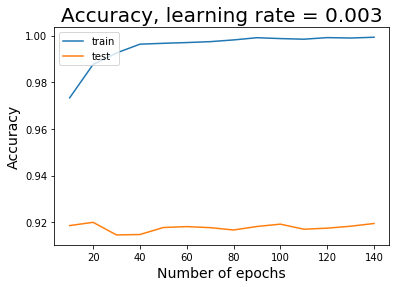

In [31]:
x = epochs_range
plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy, learning rate = ' + str(learning_rate), fontsize=20)
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

### Train turget model

In [47]:
epochs = 200
n_chunks = 1000
learning_rate = 0.003
weight_decay = 0

In [48]:
model = build_model()

In [49]:
fit_model(model, train, train_labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay)

Fitting model with epochs = 200, learning rate = 0.003
Epoch: 1/200  Loss: 0.7443
Epoch: 1/200  Loss: 0.4794
Epoch: 1/200  Loss: 0.4255
Epoch: 1/200  Loss: 0.3924
Epoch: 1/200  Loss: 0.3976
Epoch: 1/200  Loss: 0.3624
Epoch: 1/200  Loss: 0.3554
Epoch: 1/200  Loss: 0.3576
Epoch: 1/200  Loss: 0.3335
Epoch: 1/200  Loss: 0.3223
Epoch: 2/200  Loss: 0.2849
Epoch: 2/200  Loss: 0.2760
Epoch: 2/200  Loss: 0.2905
Epoch: 2/200  Loss: 0.2922
Epoch: 2/200  Loss: 0.2850
Epoch: 2/200  Loss: 0.2794
Epoch: 2/200  Loss: 0.2861
Epoch: 2/200  Loss: 0.2844
Epoch: 2/200  Loss: 0.2823
Epoch: 2/200  Loss: 0.2568
Epoch: 3/200  Loss: 0.2239
Epoch: 3/200  Loss: 0.2253
Epoch: 3/200  Loss: 0.2360
Epoch: 3/200  Loss: 0.2461
Epoch: 3/200  Loss: 0.2364
Epoch: 3/200  Loss: 0.2382
Epoch: 3/200  Loss: 0.2479
Epoch: 3/200  Loss: 0.2414
Epoch: 3/200  Loss: 0.2326
Epoch: 3/200  Loss: 0.2313
Epoch: 4/200  Loss: 0.1905
Epoch: 4/200  Loss: 0.1901
Epoch: 4/200  Loss: 0.1984
Epoch: 4/200  Loss: 0.2025
Epoch: 4/200  Loss: 0.2033


Epoch: 30/200  Loss: 0.0322
Epoch: 30/200  Loss: 0.0390
Epoch: 30/200  Loss: 0.0321
Epoch: 30/200  Loss: 0.0368
Epoch: 30/200  Loss: 0.0437
Epoch: 30/200  Loss: 0.0447
Epoch: 31/200  Loss: 0.0332
Epoch: 31/200  Loss: 0.0269
Epoch: 31/200  Loss: 0.0282
Epoch: 31/200  Loss: 0.0300
Epoch: 31/200  Loss: 0.0351
Epoch: 31/200  Loss: 0.0295
Epoch: 31/200  Loss: 0.0315
Epoch: 31/200  Loss: 0.0395
Epoch: 31/200  Loss: 0.0388
Epoch: 31/200  Loss: 0.0346
Epoch: 32/200  Loss: 0.0244
Epoch: 32/200  Loss: 0.0299
Epoch: 32/200  Loss: 0.0276
Epoch: 32/200  Loss: 0.0296
Epoch: 32/200  Loss: 0.0348
Epoch: 32/200  Loss: 0.0348
Epoch: 32/200  Loss: 0.0409
Epoch: 32/200  Loss: 0.0393
Epoch: 32/200  Loss: 0.0322
Epoch: 32/200  Loss: 0.0354
Epoch: 33/200  Loss: 0.0223
Epoch: 33/200  Loss: 0.0195
Epoch: 33/200  Loss: 0.0245
Epoch: 33/200  Loss: 0.0258
Epoch: 33/200  Loss: 0.0297
Epoch: 33/200  Loss: 0.0313
Epoch: 33/200  Loss: 0.0354
Epoch: 33/200  Loss: 0.0386
Epoch: 33/200  Loss: 0.0394
Epoch: 33/200  Loss:

Epoch: 59/200  Loss: 0.0196
Epoch: 59/200  Loss: 0.0191
Epoch: 59/200  Loss: 0.0191
Epoch: 60/200  Loss: 0.0141
Epoch: 60/200  Loss: 0.0143
Epoch: 60/200  Loss: 0.0150
Epoch: 60/200  Loss: 0.0135
Epoch: 60/200  Loss: 0.0143
Epoch: 60/200  Loss: 0.0195
Epoch: 60/200  Loss: 0.0212
Epoch: 60/200  Loss: 0.0253
Epoch: 60/200  Loss: 0.0157
Epoch: 60/200  Loss: 0.0180
Epoch: 61/200  Loss: 0.0162
Epoch: 61/200  Loss: 0.0154
Epoch: 61/200  Loss: 0.0143
Epoch: 61/200  Loss: 0.0185
Epoch: 61/200  Loss: 0.0158
Epoch: 61/200  Loss: 0.0123
Epoch: 61/200  Loss: 0.0133
Epoch: 61/200  Loss: 0.0151
Epoch: 61/200  Loss: 0.0205
Epoch: 61/200  Loss: 0.0195
Epoch: 62/200  Loss: 0.0133
Epoch: 62/200  Loss: 0.0165
Epoch: 62/200  Loss: 0.0156
Epoch: 62/200  Loss: 0.0184
Epoch: 62/200  Loss: 0.0155
Epoch: 62/200  Loss: 0.0216
Epoch: 62/200  Loss: 0.0192
Epoch: 62/200  Loss: 0.0180
Epoch: 62/200  Loss: 0.0181
Epoch: 62/200  Loss: 0.0197
Epoch: 63/200  Loss: 0.0162
Epoch: 63/200  Loss: 0.0137
Epoch: 63/200  Loss:

Epoch: 89/200  Loss: 0.0101
Epoch: 89/200  Loss: 0.0095
Epoch: 89/200  Loss: 0.0094
Epoch: 89/200  Loss: 0.0115
Epoch: 89/200  Loss: 0.0118
Epoch: 89/200  Loss: 0.0158
Epoch: 89/200  Loss: 0.0108
Epoch: 89/200  Loss: 0.0102
Epoch: 89/200  Loss: 0.0106
Epoch: 89/200  Loss: 0.0134
Epoch: 90/200  Loss: 0.0110
Epoch: 90/200  Loss: 0.0097
Epoch: 90/200  Loss: 0.0081
Epoch: 90/200  Loss: 0.0117
Epoch: 90/200  Loss: 0.0116
Epoch: 90/200  Loss: 0.0137
Epoch: 90/200  Loss: 0.0092
Epoch: 90/200  Loss: 0.0111
Epoch: 90/200  Loss: 0.0156
Epoch: 90/200  Loss: 0.0178
Epoch: 91/200  Loss: 0.0131
Epoch: 91/200  Loss: 0.0091
Epoch: 91/200  Loss: 0.0161
Epoch: 91/200  Loss: 0.0120
Epoch: 91/200  Loss: 0.0093
Epoch: 91/200  Loss: 0.0092
Epoch: 91/200  Loss: 0.0099
Epoch: 91/200  Loss: 0.0107
Epoch: 91/200  Loss: 0.0142
Epoch: 91/200  Loss: 0.0108
Epoch: 92/200  Loss: 0.0087
Epoch: 92/200  Loss: 0.0107
Epoch: 92/200  Loss: 0.0125
Epoch: 92/200  Loss: 0.0135
Epoch: 92/200  Loss: 0.0161
Epoch: 92/200  Loss:

Epoch: 117/200  Loss: 0.0081
Epoch: 117/200  Loss: 0.0079
Epoch: 117/200  Loss: 0.0100
Epoch: 118/200  Loss: 0.0081
Epoch: 118/200  Loss: 0.0127
Epoch: 118/200  Loss: 0.0097
Epoch: 118/200  Loss: 0.0110
Epoch: 118/200  Loss: 0.0103
Epoch: 118/200  Loss: 0.0133
Epoch: 118/200  Loss: 0.0123
Epoch: 118/200  Loss: 0.0115
Epoch: 118/200  Loss: 0.0121
Epoch: 118/200  Loss: 0.0133
Epoch: 119/200  Loss: 0.0067
Epoch: 119/200  Loss: 0.0041
Epoch: 119/200  Loss: 0.0060
Epoch: 119/200  Loss: 0.0090
Epoch: 119/200  Loss: 0.0136
Epoch: 119/200  Loss: 0.0110
Epoch: 119/200  Loss: 0.0086
Epoch: 119/200  Loss: 0.0115
Epoch: 119/200  Loss: 0.0103
Epoch: 119/200  Loss: 0.0120
Epoch: 120/200  Loss: 0.0088
Epoch: 120/200  Loss: 0.0095
Epoch: 120/200  Loss: 0.0065
Epoch: 120/200  Loss: 0.0096
Epoch: 120/200  Loss: 0.0089
Epoch: 120/200  Loss: 0.0079
Epoch: 120/200  Loss: 0.0112
Epoch: 120/200  Loss: 0.0094
Epoch: 120/200  Loss: 0.0102
Epoch: 120/200  Loss: 0.0103
Epoch: 121/200  Loss: 0.0082
Epoch: 121/200

Epoch: 146/200  Loss: 0.0058
Epoch: 146/200  Loss: 0.0068
Epoch: 146/200  Loss: 0.0084
Epoch: 146/200  Loss: 0.0059
Epoch: 146/200  Loss: 0.0091
Epoch: 146/200  Loss: 0.0075
Epoch: 146/200  Loss: 0.0065
Epoch: 146/200  Loss: 0.0087
Epoch: 146/200  Loss: 0.0083
Epoch: 146/200  Loss: 0.0119
Epoch: 147/200  Loss: 0.0059
Epoch: 147/200  Loss: 0.0089
Epoch: 147/200  Loss: 0.0073
Epoch: 147/200  Loss: 0.0046
Epoch: 147/200  Loss: 0.0055
Epoch: 147/200  Loss: 0.0074
Epoch: 147/200  Loss: 0.0073
Epoch: 147/200  Loss: 0.0088
Epoch: 147/200  Loss: 0.0073
Epoch: 147/200  Loss: 0.0119
Epoch: 148/200  Loss: 0.0067
Epoch: 148/200  Loss: 0.0056
Epoch: 148/200  Loss: 0.0061
Epoch: 148/200  Loss: 0.0055
Epoch: 148/200  Loss: 0.0091
Epoch: 148/200  Loss: 0.0090
Epoch: 148/200  Loss: 0.0104
Epoch: 148/200  Loss: 0.0096
Epoch: 148/200  Loss: 0.0101
Epoch: 148/200  Loss: 0.0141
Epoch: 149/200  Loss: 0.0092
Epoch: 149/200  Loss: 0.0070
Epoch: 149/200  Loss: 0.0066
Epoch: 149/200  Loss: 0.0082
Epoch: 149/200

KeyboardInterrupt: 

In [44]:
evaluate_model(model, train, train_labels, test, test_labels)

Accuracy score for train set is 0.9971825396825397
Accuracy score for test set is 0.9183333333333333


(0.9971825396825397, 0.9183333333333333)

In [45]:
filepath = '../service/models/model.nnet'

In [46]:
metainfo = {'input_size': input_size,
            'output_size': output_size,
            'hidden_layers': hidden_sizes,
            'dropout': dropout,
            'state_dict': model.state_dict()}

torch.save(metainfo, filepath)
print("Model saved to {}\n".format(filepath))

Model saved to ../service/models/model.nnet

